# All SAMI3 field line plots and Data Analysis used in the Sim Storm Paper

## Imports

In [135]:
import aacgmv2, time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math, os, shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.io import readsav
import pymap3d as pm
import glob
import datetime, statistics
from aetherpy.io import read_routines
from math import cos, radians, sin, sqrt
from scipy import spatial, signal

from spacepy.coordinates import Coords
from spacepy.time import Ticktock
import fnmatch

import gc

import sys
from mpl_toolkits.basemap import Basemap
import geopandas

from scipy.interpolate import LinearNDInterpolator, interp1d, griddata

%matplotlib inline

## Settings

In [2]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 

dtime_sim_start = datetime.datetime(2011,5,20)

t_step_minutes = 5 # minutes


plot_start_delta  = 4  # hours before storm onset to start making plots. set to -1 to run the whole time
plot_end_delta    = -1  # hours after storm onset to end plots. Set to -1 to run for the whole time

sami_data_path = "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/SAMI3-stretch/"

lon_keos = [-90,2,90,-178]

global_lat_lim = None # will limit all plots latitude. Must be none or less than keo_lat_lim
# ^^ Needs to be tested.

keo_lat_lim = 65 # limits keos to +/- degrees of lat. 

OVERWRITE = True # be careful!

num_pool_workers = int(0.75 * os.num_cpus) # number of workers to use in multithreading jobs. Set to 1 if you don't know what this means. 

both_map_plots = True # make both_map_plots filtered and raw maps? if you only want one put it as a str ('raw'/'filt')

sample_rate_min = 5 #min
low_cut = 100 # min, lowest freq wave the filter will allow thru
high_cut = 30 # min, highest freq the filter will allow thru

mlons_to_plot = 10 #number of field lines you want to plot. Not necessary. You can set to none if you want to plot stuff yourself


In [3]:
sami_fieldline_plots = "/home/axb170054/scratch/made_plots/SimStormPaper/SAMI/fieldlines/"
sami_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/SAMI/keos/"
sami_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/SAMI/maps/"

In [4]:
field_line_alt_max = 1200
field_line_lat_lim = 60


In [5]:
cols = ['edens', 'hplusdens', 'oplusdens', 'noplusdens', 'o2plusdens', 'heplusdens', 'n2plusdens', 'nplusdens', 'hdens', 'odens', 'nodens', 'o2dens', 'hedens', 'n2dens', 'ndens']

# above is all cols (that I care about), below is just edens.

#cols = ['edens']

Available columns (for now) are:

['edens', 'hplusdens', 'oplusdens', 'noplusdens', 'o2plusdens', 'heplusdens', 'n2plusdens', 'nplusdens', 'hdens', 'odens', 'nodens', 'o2dens', 'hedens', 'n2dens', 'ndens']

## Constants:

In [6]:
geo_grid_files = {'glat':'glatu.dat','glon':'glonu.dat','alt':'zaltu.dat', 
                  'mlat':'blatu.dat','mlon':'blonu.dat','malt':'baltu.dat'}


data_files = {'edens':'deneu.dat', 'hplusdens':'deni1u.dat','oplusdens':'deni2u.dat',
              'noplusdens':'deni3u.dat', 'o2plusdens':'deni4u.dat',
              'heplusdens':'deni5u.dat', 'n2plusdens':'deni6u.dat', 
              'nplusdens':'deni7u.dat','hdens':'denn1u.dat','odens':'denn2u.dat', 
              'nodens':'denn3u.dat', 'o2dens':'denn4u.dat', 'hedens':'denn5u.dat', 
              'n2dens':'denn6u.dat', 'ndens':'denn7u.dat'}

time_file = 'time.dat'

## Define Functions

In [7]:
def get_grid_elems_from_parammod(data_dir):
    """
    Will look for: words = ['nz0','nf','nl'] in SAMI files.
    
    inputs:
    ------
    sami path
    
    outputs:
    -------
    nz,nf,nlt,nt :
    - nz  = num points along field line
    - nf  = num field lines along each mag lon
    - nlt = num mag lons
    - nt  = num times
    
    """
    
    #Make sure that we only grab the first instance of each var in the file. 
        # SOmetimes they repeat and we don't want them
    returns = [False, False, [False, False], False]
    
    with open(data_dir  + 'parameter_mod.f90', 'r') as fp:
    # read all lines in a list
        lines = fp.readlines()
        for line in lines:
            # check if string present on a current line
            
            if not returns[0]:
                if line.find('nz0') != -1:
                    nz0 = []
                    for l in line:
                        if l.isdigit():
                            nz0.append(l)
                    if len(nz0[1:4]) == 3:
                        nz = int(''.join(nz0[1:4]))
                        returns[0] = True
            
            if not returns[1]:
                if line.find('nf') != -1:
                    nf = []
                    for l in line:
                        if l.isdigit():
                            nf.append(l)
                    nf = int(''.join(nf))
                    returns[1] = True
                    
            if not returns[2][0]:
                if line.find('nl ') != -1:
                    nl = []
                    for l in line:
                        if l.isdigit():
                            nl.append(l)
                    nl = int(''.join(nl))
                    returns[2][0] = True
                    
            if not returns[2][1]:
                if line.find('numwork ') != -1:
                    numwork = []
                    for l in line:
                        if l.isdigit():
                            numwork.append(l)
                    numwork = int(''.join(numwork))
                    returns[2][1] = True
                    
    #time
    with open(data_dir  + 'time.dat', 'r') as fp:
        lines = fp.readlines()
        nt = len(lines) - 1
            
    return nz, nf, numwork*(nl - 2), nt



In [35]:
def make_times(t0, nt, plot_start_delta = None, plot_end_delta = None):
    times = []
    hrs_since_storm_start = []
    
    for t in range(nt):
        time_here = pd.Timestamp(dtime_sim_start) + t * pd.Timedelta(5, 'minutes')
        times.append(time_here.to_pydatetime())
        hrs = (time_here - dtime_storm_start)/pd.Timedelta(1, 'hour')
        hrs_since_storm_start.append(hrs)
        
        
        
    times_df = pd.read_fwf(os.path.join(sami_data_path, 'time.dat'), 
                            names = ['istep', 'hour', 'minute', 'second', 'hrdelta'], infer_nrows=115)
    times_df.pop('istep');

    times_list = []
    for hr in times_df['hrdelta']:
        times_list.append(dtime_sim_start + datetime.timedelta(hours = hr))    
    
    truths = np.array([pd.Timestamp(times_list[t]).round('T') == times[t] for t in range(len(times))])
    if truths.sum() != len(truths):
        raise ValueError('The times are wrong! Somehow this needs to be fixed. probably outputting fake files again. Take a look and debug before proceeding.')
        
    #maybe chop the time lists, depending on if the plot start/end are given.
    # adjusted to allow for -1 in plot start/end deltas (plot all times)
        
    if plot_start_delta and plot_end_delta:
        if plot_start_delta != -1:
            start_idx = np.argmin(np.abs(np.array(times) 
                                     - (dtime_storm_start - pd.Timedelta(plot_start_delta, 'hour'))))
        else:
            start_idx = 0
            
        if plot_end_delta != -1:
            end_idx = plot_end_delta
        elif plot_end_delta == -1:
            end_idx = len(times)
        else:
            end_idx = len(times)
        
        times = times[start_idx:end_idx]
        hrs_since_storm_start = hrs_since_storm_start[start_idx:end_idx]
        times_list = times_list[start_idx:end_idx]
        
        return times, hrs_since_storm_start, times_list, (start_idx, end_idx)
        
    elif plot_start_delta != plot_end_delta:
        raise ValueError('You cannot specify one and not the other!')
    
    return times, hrs_since_storm_start, times_list

In [9]:
def UT_from_Storm_onset(itime):
    """input a datetime
    
    returns the UT as HH:MM from storm onset, as a string"""
    l = (pd.Timestamp(itime) - dtime_storm_start)/ pd.Timedelta('1 minute') # get pd datetime of this iter, find minute diff from storm start
    if l > 0:
        hrs = np.floor(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    else:
        hrs = np.ceil(l/60)
        hrs = '-' + str(np.abs(int(hrs))).rjust(2,'0')
    mins = str(int(np.abs(l)%60)).rjust(2,'0')
    ut = hrs + ':' + mins
    return ut

In [10]:
def get_sami_grid(sami_data_path = sami_data_path, geo_grid_files = geo_grid_files):

    grid = {}

    for f in geo_grid_files:
        file = open(os.path.join(sami_data_path, geo_grid_files[f]), 'rb')
        raw = np.fromfile(file, dtype='float32')[1:-1].copy()
        file.close()

        grid[f] = raw.reshape(nlt,nf,nz).copy()
    return grid

In [11]:
def read_sami_data(cols, nts):
    """
    Read in sami data for the specified columns and return sama data dict
    
    inputs:
    -------
    cols: list-like
        - Columns you want data for. Does not have to be everything
    
    nts: int OR tuple/list
        - either nt (number of times) if you want all sami data from simulation or:
        - nts (start_time, end_time) if you want plots from a select time period.
    
    """
    sami_data = {}
    
    #handle cut time list and full time list
    if type(nts) != int:
        t_start = nts[0]
        t_end   = nts[1]
        ntimes = t_end - t_start
    else:
        t_start = 0
        t_end = nt
        ntimes = nt
        
    pbar = tqdm(total = len(cols) * ntimes)

    for f in cols:

        sami_data[f] = np.zeros((nlt,nf,nz,ntimes))

        file = open(os.path.join(sami_data_path, data_files[f]), 'rb')
        for t in range(t_end):
            raw = np.fromfile(file, dtype='float32', count = (nz*nf*nlt)+2)[1:-1]
            if t >= t_start:
                sami_data[f][:,:,:,t-t_start] = raw.reshape(nlt,nf,nz).copy()
                pbar.update(1)
        file.close()
    pbar.close()
        
    return sami_data

In [12]:
def make_filter(params = None):
    # Define the cutoff frequencies
    lowcut = 1/(100/60)  # 100 minutes in units of sample^-1
    highcut = 1/(30/60) # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5 # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(2, [low, high], btype='bandstop', output='sos')
    return sos

def remove_background(time_series, sos):


    # Apply the filter to the time series
    filtered_data = signal.sosfiltfilt(sos, time_series)

    return filtered_data

def make_fits(gitm_bins):
    """
    calculate bandpass filter for all data previously read in.
    
    inputs: nparray of gitmdata
    
    returns:
    fits: np array indexed at fits[time][col][ilon][ilat][ialt]

    
    todo: you can thread this by splitting the alts into different threads.
    then just append the fits_full later.
    
    """
    sos = make_filter()
    filtered_arr = {}
    for col in cols:
        filtered_arr[col] = signal.sosfiltfilt(sos, sami_data[col], axis=3)
    return filtered_arr

In [133]:
def draw_fieldline_scatter_plot(x, y, z, time_index, fpeak_col_data, lon_real,
                                cbar_label = None, save_or_show = 'show', 
                                fname = None, colorbar_lims = None,
                                y_label = 'Altitude (km)', x_label = 'Magnetic Latitude (deg)', 
                                title = None,fpeak = False, interpolate = False ):
    
    plt.figure(figsize = (8,5))
    
    if colorbar_lims == None:
        colorbar_lims = [min(z), max(z)]
    
    if interpolate:
        xmin = min(x)
        xmax = max(x)
        ymin = min(y)
        ymax = max(y)

        points = np.vstack((np.array(x),np.array(y))).T
        grid_x,grid_y = np.meshgrid(np.linspace(xmin,xmax,360),np.linspace(ymin,ymax,200))
        fitted_values = griddata(points, z, (grid_x,grid_y))
        plt.pcolormesh(grid_x,grid_y,fitted_values, vmin = colorbar_lims[0], vmax = colorbar_lims[1])
        
    else:
        plt.scatter(x, y, c = z, vmin = colorbar_lims[0], vmax = colorbar_lims[1])
        plt.ylim(0, field_line_alt_max)
        
        plt.xlim(-field_line_lat_lim, field_line_lat_lim)
    
    
    plt.colorbar(label = cbar_label)
    
    # plt.title(title)
    plt.figtext(.5,.9,title, fontsize=12, ha='center')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if fpeak:
        xs = []
        ys = []
        if lon_real == None:
            raise ValueError('Longitude must be given if fpeak is selected')
        mlat_lims = []
        for i in range(-field_line_lat_lim, field_line_lat_lim,2):
            mlat_lims.append([i, i+2])
        mlat_masks = []
        for l in mlat_lims:
            mlat_masks.append((x < l[1]) & (x > l[0]) & (np.abs(y) < field_line_alt_max) & (np.abs(x)  < field_line_lat_lim+2 ))

        for mask in mlat_masks:
            max_here = np.argmax(fpeak_col_data[mask])
            
            xs.append(x[mask][max_here])
            ys.append(y[mask][max_here])

        #smooth the line a bit:
        cubic_interpolation_model = interp1d(xs, ys, kind = "cubic")
 
        # Plotting the Graph
        newx = np.linspace(min(xs), max(xs), 100)
        newy = cubic_interpolation_model(newx)
        plt.plot(newx, newy, color = 'k')
        
        
    
    if save_or_show == 'show':
        plt.show()
        plt.close()
    elif save_or_show == 'save':
        if not fname:
            raise ValueError('plot save path must be given!')
        else:
            # fname = fname.replace(' ','')
            try:
                plt.savefig(fname)
            except FileNotFoundError:
                try:
                    directory_list = os.path.join(fname).split('/')[:-1]
                    os.makedirs('/'+os.path.join(*directory_list))
                    plt.savefig(fname)
                except FileExistsError:
                    time.sleep(2) # sometimes when we make too many plots in the same directory, it fails. this fixes that.
                    try:
                        plt.savefig(fname)
                    except FileNotFoundError:
                        time.sleep(2)
                        plt.savefig(fname)

            except:
                print(fname)
                raise ValueError
            plt.close()
            gc.collect()
    else:
        raise ValueError('save_or_show input is invalid. Accepted inputs are "save" or "show", you gave ', save_or_show)
        

In [14]:
def remove_outliers(array):
    arr2 = array.copy()
    mean, std, median = np.mean(arr2), np.std(arr2), np.median(arr2) # calculate mean, standard deviation, and median over all elements
    outlier_threshold = 5 # set outlier threshold (in terms of number of standard deviations)
    outliers = np.logical_or(arr2 < mean - outlier_threshold * std, arr2 > mean + outlier_threshold * std) # find outliers
    arr2[outliers] = median # set outliers to median
    return arr2

In [128]:
def call_field_line_drawing(col, lon_idx = None, time_index = None,
                            figtype = 'all', interpolate = False, fpeak = False,
                            save_or_show = 'show', dtime_here = None, fpeak_col = 'edens'):
    #fix & check inputs
    # if None in [time_index, time_real]:
    #     if time_index == None:
    #         if time_real == None:
    #             raise ValueError('the time must be specified somehow, please')
    #         time_index = np.argmin(times - time_real)
    #         time_real = times[time_idx] #in case it's off by a bit. 
    #     if time_real == None:
    #         if time_index == None:
    #             raise ValueError('the time must be specified somehow, please')
    #         time_real = times[time_index]
            
    if lon_idx == None:
        raise ValueError('the lon must be specified somehow, please ')
    lon_real = mlons[lon_idx]
    
    
    if time_index == None and dtime_here == None:
        raise ValueError('Time must be given. you should probably use loop_fieldlines')
    elif time_index == None:
        time_index = times.index(dtime_here)
    elif dtime_here == None:
        dtime_here = times[time_index]
    
    #plot params
    plotlim_mask = (np.abs(grid['alt']) < field_line_alt_max) & (
        np.abs(grid['mlat'])  < field_line_lat_lim+2 )
    mask2 = (plotlim_mask) & (np.abs(grid['mlon'] - lon_real) < 0.2)
    
    raw = sami_data[col][mask2].copy()
    fit = fits_sami[col][mask2].copy()
    
    raw = remove_outliers(raw)
    fit = remove_outliers(fit)
    diff = 100*(raw - fit)/fit
    # diff = remove_outliers(diff) # we have enforced global colorlimits so we don't need this. We can fix it later. Maybe add an option to change colorbar limits based on which column we're plotting
    
    vmin_raw = np.min(raw)
    vmax_raw = np.max(raw)
    
    vmin_fit = np.min(fit)
    vmax_fit = np.max(fit)
    
    vmin_diffs = -2 #np.min(diff)
    vmax_diffs =  2 # np.max(diff)


    # get data:
    x, y = grid['mlat'][mask2].flatten(), grid['alt'][mask2].flatten()
    color_raw = sami_data[col][:,:,:,time_index][mask2].flatten()
    color_fit = fits_sami[col][:,:,:,time_index][mask2].flatten()

    percent = 100*(color_raw - color_fit) / color_fit
    
    

        
    plot_loops = [[],[]] # to facilitate us setting fpeak and interpolate to both or T/F
    
    # Interpolate can be set to True/False/'both'. If both, do the plot routine twice:
    if interpolate == 'both':
        plot_loops[0] = [True, False]
    else:
        plot_loops[0] = [interpolate]
    #same for fpeak:
    if fpeak == 'both':
        plot_loops[1] = [True, False]
    else:
        plot_loops[1] = [fpeak]
    
        
    #loop thru plot_loops, which it basically just interpolate and fpeak options.
    for interpolate in plot_loops[0]:
        for fpeak in plot_loops[1]:
            # set string names, change title based on options.
            fname = os.path.join(sami_fieldline_plots, 'plot_type','lon'+str(int(lon_real)), 
                                 col,'scatter','no-fpeak', str(time_index).rjust(3,'0') + '.png')

            if interpolate:
                fname = fname.replace('scatter','interpolated')
            if fpeak:
                fname = fname.replace('no-fpeak','f-peak')
            else:
                fpeak_data = None
                

            mlt = aacgmv2.wrapper.convert_mlt(lon_real, dtime_here, m2a=False).round(2)[0]

            title = '%s along blon =  %s (deg), \n %s From Storm Onset, MLT = %s' %(col, str(lon_real.round(2)), 
                                                                    UT_from_Storm_onset(dtime_here), str(mlt))
            
            # get one more piece of data:
                    # max value in fpeak col for each time
            fpeak_data = sami_data[fpeak_col][mask2].T[time_index].copy()


            if figtype == 'all' or 'raw' in figtype:

                clabel = 'raw'

                draw_fieldline_scatter_plot(x, y, z = color_raw, cbar_label=clabel, 
                                            title = title, time_index = time_index,
                                            fpeak = fpeak, save_or_show = save_or_show,
                                            interpolate = interpolate, lon_real = lon_real,
                                            fpeak_col_data = fpeak_data,
                                            fname = fname.replace('plot_type', 'raw'), 
                                            colorbar_lims = [vmin_raw, vmax_raw])

            if figtype == 'all' or 'filt' in figtype:

                clabel = 'Bandpass Filter'

                draw_fieldline_scatter_plot(x, y, z = color_fit, 
                                            cbar_label=clabel, title = title, 
                                            fpeak = fpeak, save_or_show = save_or_show,lon_real = lon_real,
                                            interpolate = interpolate, time_index = time_index,
                                            fpeak_col_data = fpeak_data,
                                            colorbar_lims = [vmin_fit, vmax_fit],
                                            fname = fname.replace('plot_type', 'filt'))

            if figtype == 'all' or 'diff' in figtype:

                clabel = '% over background'

                draw_fieldline_scatter_plot(x, y, z = percent, 
                                            cbar_label=clabel, title = title, 
                                            fpeak = fpeak, save_or_show = save_or_show,lon_real = lon_real,
                                            interpolate = interpolate, time_index = time_index,
                                            fpeak_col_data = fpeak_data,
                                            colorbar_lims = [vmin_diffs, vmax_diffs],
                                            fname = fname.replace('plot_type', 'diff'))

    
    

In [125]:
def thread_make_fieldlines(args):
    call_field_line_drawing(col = args[0], lon_idx = args[1], interpolate=args[2],
                           dtime_here=args[3], fpeak=args[4], fpeak_col=args[5], 
                           save_or_show=args[6])

In [126]:
def loop_field_line_drawings(cols = data_files.keys(), lon_idxs = -1, fpeak_col = 'edens',
                             thread = True, interpolate = 'both', fpeak = 'both', times_to_plot = -1, save_or_show = 'save'):
    # make all the inputs make sense
    if type(cols) == str:
        cols = [cols]
        
    if times_to_plot == -1:
        dtimes_to_plot = times
    elif type(times_to_plot) == int:
        dtimes_to_plot = [times[times_to_plot]]
        
    if lon_idxs == -1:
        lon_idxs = mlon_idxs
    elif type(lon_idxs) == int:
        lon_idxs = [mlons[lon_idxs]]
        
    # loop single threaded, then loop multithreaded.
    
    if not thread:
        pbar = tqdm(desc = 'making field line plots sequentially...', 
                    total = len(cols) * len(lon_idxs) * len(dtimes_to_plot))
        
        for namecol in cols:
            for num_lon in lon_idxs:
                for numt in dtimes_to_plot:
                    call_field_line_drawing(namecol, lon_idx = numlon, 
                                            interpolate = interpolate, fpeak = fpeak,
                                            fpeak_col = fpeak_col, time_index= numt)
                    pbar.update(1)
    else:
        arg_arr = []
        print("thread is True. Building array and launching pool... (pbar is just an estimate. It will not be 100% accurate since we're threading.)")
        
        for namecol in cols:
            for num_lon in lon_idxs:
                for treal in dtimes_to_plot:
                    arg_arr.append([namecol, num_lon, interpolate, treal, fpeak, fpeak_col, save_or_show])
        with Pool(num_pool_workers) as pool:
            with tqdm(desc = 'threading fieldline plot making', total = len(arg_arr), miniters = int(len(arg_arr)/num_pool_workers)) as pbar:
                for _ in pool.imap_unordered(thread_make_fieldlines, arg_arr):
                    pbar.update(1)  
    

## Some setup

## Read in data

In [38]:
nz, nf, nlt, nt = get_grid_elems_from_parammod(sami_data_path)

In [39]:
times, hrs, times_list, nts = make_times(dtime_sim_start, nt, plot_start_delta, plot_end_delta)
new_nt = np.diff(nts)[0]

In [40]:
## OR.... to run for all times:
# times, hrs, times_list = make_times(dtime_sim_start, nt)


In [41]:
print(nlt, nf, nz, nts, new_nt)
nt = new_nt

80 72 256 (404, 615) 211


In [42]:
grid = get_sami_grid()

In [43]:
for g in grid.keys():
    print(g, grid[g].shape)

glat (80, 72, 256)
glon (80, 72, 256)
alt (80, 72, 256)
mlat (80, 72, 256)
mlon (80, 72, 256)
malt (80, 72, 256)


In [44]:
# sami grid
sami_data = read_sami_data(cols, nts)
# or
# sami_data = read_sami_data(cols, nt)

print('sami data shape: ', sami_data[cols[0]].shape)

  0%|          | 0/3165 [00:00<?, ?it/s]

sami data shape:  (80, 72, 256, 211)


In [45]:
print('Calculating fits. This will take a moment...')
fits_sami = make_fits(sami_data)

Calculating fits. This will take a moment...


## more setup:

In [46]:
mlons = np.unique(grid['mlon'].round(3))

In [47]:
mlon_step = np.floor((len(mlons) +1) / mlons_to_plot)
mlon_idxs = list(range(0,nlt,int(mlon_step)))

In [48]:
print('we will plot %i mlons, here are the indices & the actual mlon:' %len(mlon_idxs))
[print(i, mlons[i]) for i in mlon_idxs];

we will plot 10 mlons, here are the indices & the actual mlon:
0 2.25
8 38.25
16 74.25
24 110.25
32 146.25
40 182.25
48 218.25
56 254.25
64 290.25
72 326.25


## Field line plots

In [49]:

# call_field_line_drawing(col = 'edens', lon_idx = 50, 
#                         interpolate = False, fpeak = True,
#                         save_or_show = 'save')
# call_field_line_drawing(col = 'edens', lon_idx = 50, 
#                         interpolate = True, fpeak = True,
#                         save_or_show = 'save')

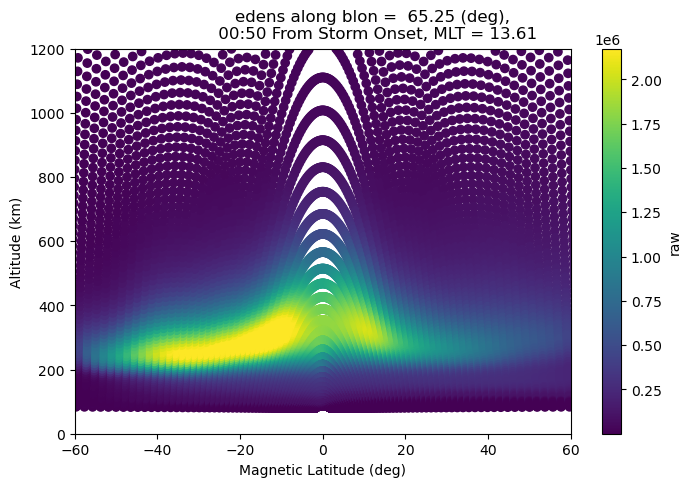

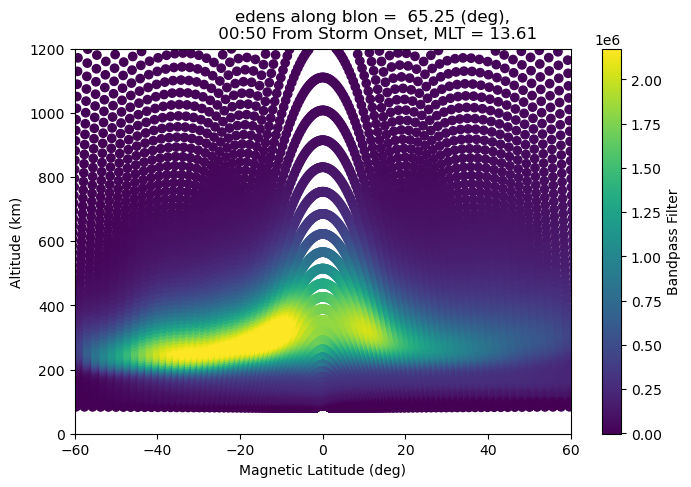

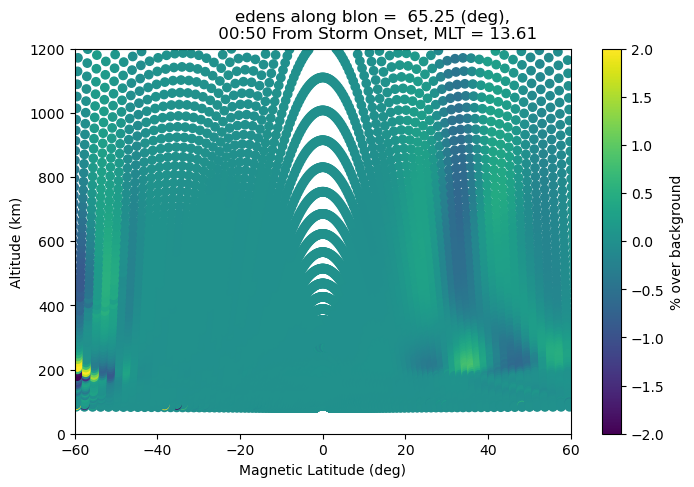

In [129]:
# a few plots in console
call_field_line_drawing(col = 'edens', lon_idx = 14, 
                        interpolate = False, fpeak = False,
                        save_or_show = 'show', time_index = 58)

In [134]:
# Make and save all of the plots:

# this
loop_field_line_drawings()


#is the same as this:
# loop_field_line_drawings(cols = sami_data.keys(), lon_idxs = -1, fpeak_col = 'edens',
#                              thread = True, interpolate = True, fpeak = True, times_to_plot = -1)

thread is True. Building array and launching pool... (pbar is just an estimate. It will not be 100% accurate since we're threading.)


threading fieldline plot making:   0%|          | 0/31650 [00:00<?, ?it/s]